In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



In [55]:
df = pd.read_csv("../data/SERSIC/delight_sersic.csv", dtype={'objID': 'Int64'})

In [ ]:
ser_columns = [
    "objID", "host_ra", "host_dec", "hostsize",
    "rSerRadius", "rSerAb", "rSerPhi", "rSerChisq", "rSerRa", "rSerDec",
]

In [ ]:
df_sersic = (
    df.dropna(subset=ser_columns)                        # Eliminamos ejemplos con nan
      .loc[~(df[ser_columns] == -999).any(axis=1)]       # Eliminamos ejemplos con -999
      [ser_columns]
      .drop_duplicates(subset="objID")                   # Eliminamos galaxias duplicadas
)

In [51]:
oid_train = np.load("..\data\DELIGHT\id_train.npy",allow_pickle=True)
oid_val = np.load("..\data\DELIGHT\id_validation.npy",allow_pickle=True)

idx_train = df[df['oid'].isin(oid_train)].index.to_numpy()
idx_val = df[df['oid'].isin(oid_val)].index.to_numpy()
idx_test = np.setdiff1d(df.index, np.union1d(idx_train, idx_val))

idx_train_sersic = df_sersic.index.values

In [ ]:
not_in_sersic_train = np.setdiff1d(df.index, idx_train_sersic)

In [61]:
idx_val_sersic = np.intersect1d(idx_val, not_in_sersic_train)
idx_test_sersic = np.intersect1d(idx_test, not_in_sersic_train)

In [ ]:
resto_idx = np.setdiff1d(df.index, np.concatenate([idx_train_sersic , idx_val_sersic, idx_test_sersic]))

In [92]:
# Bins definidos
bins = np.linspace(0, 140, 10)

# Obtener los valores de hostsize para los índices restantes
resto_idx = np.setdiff1d(df.index, np.concatenate([idx_train_sersic , idx_val_sersic,idx_test_sersic]))
hostsizes_resto = df.loc[resto_idx, "hostsize"].values

# Asignar a cada valor un bin
hostsize_bins = np.digitize(hostsizes_resto, bins)

# Inicializar listas para los splits estratificados
strat_val_idx = []
strat_test_idx = []

# Recorrer cada bin y hacer split proporcional
for bin_id in np.unique(hostsize_bins):
    # Índices dentro del bin actual
    idx_in_bin = resto_idx[hostsize_bins == bin_id]
    
    # Mezclar aleatoriamente
    np.random.seed(0)  # para reproducibilidad
    shuffled = np.random.permutation(idx_in_bin)
    
    # 50/50 split
    split_point = len(shuffled) // 2
    strat_val_idx.append(shuffled[:split_point])
    strat_test_idx.append(shuffled[split_point:])

# Concatenar todos los índices
strat_val_idx = np.concatenate(strat_val_idx)
strat_test_idx = np.concatenate(strat_test_idx)

In [96]:
idx_val_final_sersic = np.concatenate([idx_val_sersic, strat_val_idx])
idx_test_final_sersic = np.concatenate([idx_test_sersic, strat_test_idx])

In [107]:
train_oid_sersic = df["oid"][idx_train_sersic]
val_oid_sersic = df["oid"][idx_val_final_sersic]
test_oid_sersic = df["oid"][idx_test_final_sersic]

In [112]:
np.save(f'..\data\SERSIC/id_train.npy', train_oid_sersic)
np.save(f'..\data\SERSIC/id_validation.npy', val_oid_sersic)
np.save(f'..\data\SERSIC/id_test.npy', test_oid_sersic)


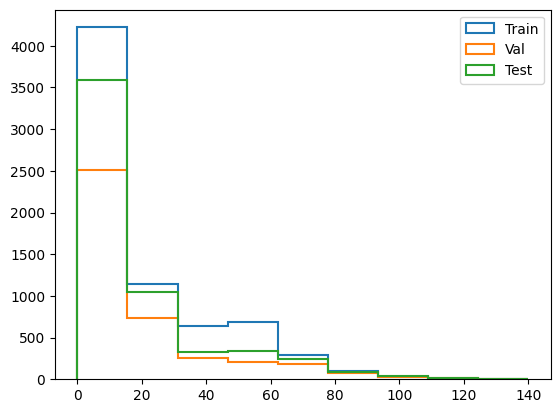

In [102]:
bins= np.linspace(0,140,10)
plt.hist(df.iloc[idx_train_sersic]["hostsize"], bins=bins, histtype="step", label="Train", linewidth=1.5)
plt.hist(df.iloc[idx_val_final_sersic]["hostsize"], bins=bins, histtype="step", label="Val", linewidth=1.5)
plt.hist(df.iloc[idx_test_final_sersic]["hostsize"], bins=bins, histtype="step", label="Test", linewidth=1.5)
plt.legend()
plt.show()

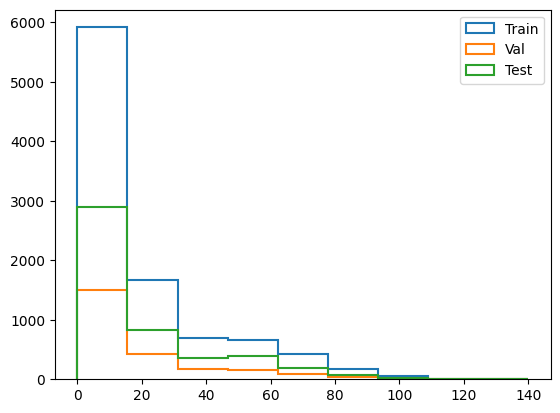

In [113]:
bins= np.linspace(0,140,10)
plt.hist(df.iloc[idx_train]["hostsize"], bins=bins, histtype="step", label="Train", linewidth=1.5)
plt.hist(df.iloc[idx_val]["hostsize"], bins=bins, histtype="step", label="Val", linewidth=1.5)
plt.hist(df.iloc[idx_test]["hostsize"], bins=bins, histtype="step", label="Test", linewidth=1.5)
plt.legend()
plt.show()